<a href="https://colab.research.google.com/github/Mena-SA-Kamel/cell-features/blob/feature%2Fvae/VAE_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using Variational Autoencoder to Extract Feature Embeddings from MNIST

In [1]:
# Python helpers
import os
import numpy as np

# Torch model imports
import torch
import torch.nn as nn

# Torch dataset imports
from torchvision.datasets import MNIST

# Torch data loader + transforms
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

# Plotting functions
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.utils import save_image, make_grid

Creating Transforms

In [2]:
transform = transforms.Compose([transforms.ToTensor()])
# download the MNIST datasets
path = '/content/datasets'
if not os.path.exists(path):
  os.makedirs(path, exist_ok=True)

train_dataset = MNIST(path, transform=transform, download=True)
test_dataset  = MNIST(path, transform=transform, download=True)

In [10]:
batch_size = 100
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

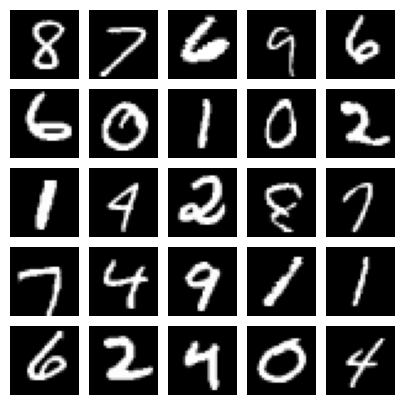

In [4]:
# Creating an iterator for the training data
num_samples = 25
dataiter = iter(train_loader)
image = next(dataiter)
sample_images = [image[0][i,0] for i in range(num_samples)]

fig = plt.figure(figsize=(5, 5))
grid = ImageGrid(fig, 111, nrows_ncols=(5, 5), axes_pad=0.1)

for ax, im in zip(grid, sample_images):
    ax.imshow(im, cmap='gray')
    ax.axis('off')

plt.show()

Defining the VAE class

In [14]:
class VAE(nn.Module):
  def __init__(self, input_dim=784, hidden_dim=400, latent_dim=200, device=device):
    super(VAE, self).__init__()

    #Encoder
    self.encoder = nn.Sequential(
        nn.Linear(input_dim, hidden_dim),
        nn.LeakyReLU(0.2),
        nn.Linear(hidden_dim, latent_dim),
        nn.LeakyReLU(0.2)
    )

    # Latent mean and variance
    self.mean_layer = nn.Linear(latent_dim, 2)
    self.logvar_layer = nn.Linear(latent_dim, 2)

    # Decoder
    self.decoder = nn.Sequential(
        nn.Linear(2, latent_dim),
        nn.LeakyReLU(0.2),
        nn.Linear(latent_dim, hidden_dim),
        nn.LeakyReLU(0.2),
        nn.Linear(hidden_dim, input_dim),
        nn.Sigmoid()
    )

  def encode(self, x):
    x = self.encoder(x)
    mean, logvar = self.mean_layer(x), self.logvar_layer(x)
    return mean, logvar

  def reparametrization(self, mean, var):
    epsilon = torch.randn_like(var).to(device)
    z = mean + var*epsilon
    return z

  def decode(self, x):
    return self.decoder(x)

  def forward(self, x):
    mean, logvar = self.encode(x)
    z = self.reparametrization(mean, logvar)
    x_hat = self.decode(z)
    return x_hat, mean, logvar




In [16]:
def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return reproduction_loss + KLD

def train(model, optimizer, epochs, device, train_loader, x_dim=784):
    model.train()
    for epoch in range(epochs):
      overall_loss = 0
      for batch_idx, (x,_) in enumerate(train_loader):
        x = x.view(batch_size, x_dim).to(device)
        optimizer.zero_grad()
        x_hat, mean, log_var = model(x)
        loss = loss_function(x, x_hat,mean, log_var)
        overall_loss += loss.item()
        loss.backward()
        optimizer.step()
      print("\tEpoch", epoch + 1, "\tAverage Loss: ", overall_loss/(batch_idx*batch_size))
    return overall_loss

In [17]:
# %env CUDA_LAUNCH_BLOCKING=1
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
print (device)
model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
train(model, optimizer, epochs=50, device=device, train_loader=train_loader)

cuda
	Epoch 1 	Average Loss:  177.68807446003757
	Epoch 2 	Average Loss:  157.08458022485394
	Epoch 3 	Average Loss:  152.69585533180302
	Epoch 4 	Average Loss:  150.40420823442716
	Epoch 5 	Average Loss:  148.76911630060516
	Epoch 6 	Average Loss:  147.25359895072518
	Epoch 7 	Average Loss:  146.06849994130843
	Epoch 8 	Average Loss:  145.0859507219063
	Epoch 9 	Average Loss:  144.30751449355697
	Epoch 10 	Average Loss:  143.7012408212907
	Epoch 11 	Average Loss:  142.81863630138773
	Epoch 12 	Average Loss:  142.4462584776711
	Epoch 13 	Average Loss:  142.01040710754904
	Epoch 14 	Average Loss:  141.31273196212436
	Epoch 15 	Average Loss:  140.8854659132408
	Epoch 16 	Average Loss:  140.2974268800866
	Epoch 17 	Average Loss:  140.03366504395348
	Epoch 18 	Average Loss:  139.89992348901816
	Epoch 19 	Average Loss:  139.4006472538867
	Epoch 20 	Average Loss:  139.11687685856637
	Epoch 21 	Average Loss:  138.69367264125106
	Epoch 22 	Average Loss:  138.39930595589001
	Epoch 23 	Average L

8027833.404296875

In [18]:
def generate_digit(mean, var):
    z_sample = torch.tensor([[mean, var]], dtype=torch.float).to(device)
    x_decoded = model.decode(z_sample)
    digit = x_decoded.detach().cpu().reshape(28, 28) # reshape vector to 2d array
    plt.title(f'[{mean},{var}]')
    plt.imshow(digit, cmap='gray')
    plt.axis('off')
    plt.show()

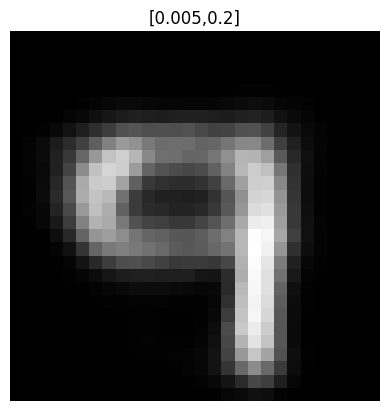

In [34]:
generate_digit(0.005, 0.2)